# First Try at Housing Kaggle competition

First, let's load some useful libraries and load the available data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge,Lasso,LinearRegression
from sklearn import preprocessing
from scipy.stats import skew
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df_train=pd.read_csv('data/train.csv')
df_train=df_train.drop('Id',axis=1)
df_train=df_train.fillna(df_train.mean())
df_train=df_train.fillna('xx')

df_test=pd.read_csv('data/test.csv')
df_test=df_test.drop('Id',axis=1)
df_test=df_test.fillna(df_test.mean()) 
df_test=df_test.fillna('xx')

## Visualizing the data

Let's see what is in the data and how variables relate with the objective variable "SalePrice"

In [3]:
print(list(df_train))

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fen

In [4]:
def plot_feature(fname, df):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 10))
    ax[0].hist(df[fname],bins=50)
    ax[1].plot(df[fname], df["SalePrice"],'rx')
    ax[1].set_ylabel('SalePrice')
    ax[1].set_xlabel(fname)
    return fig, ax

Let's plot some features:

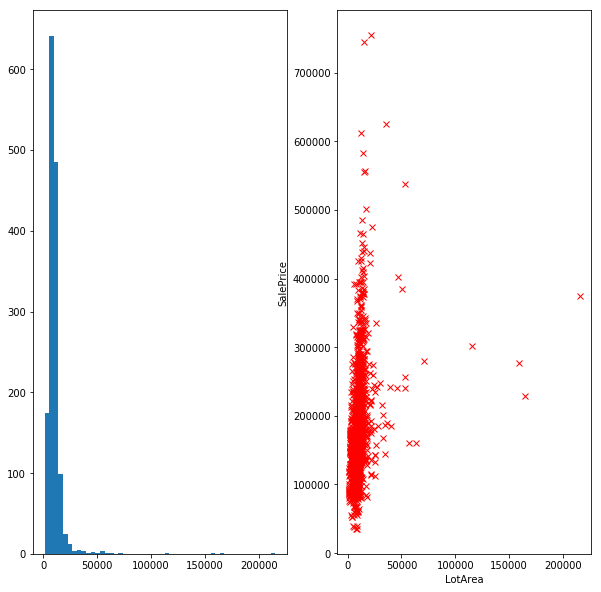

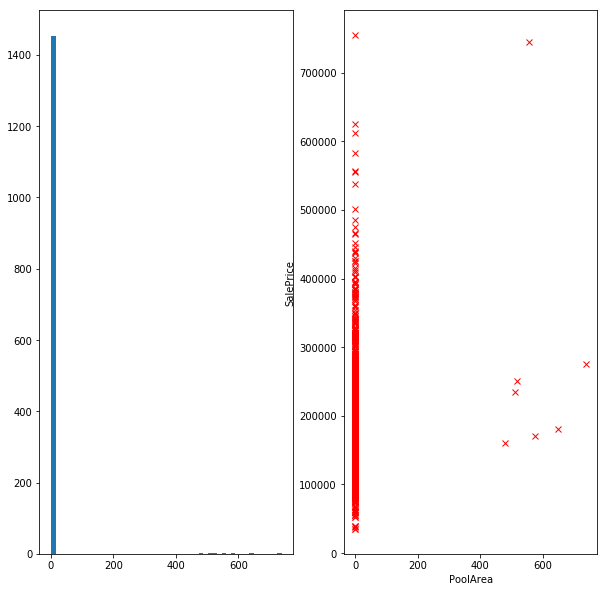

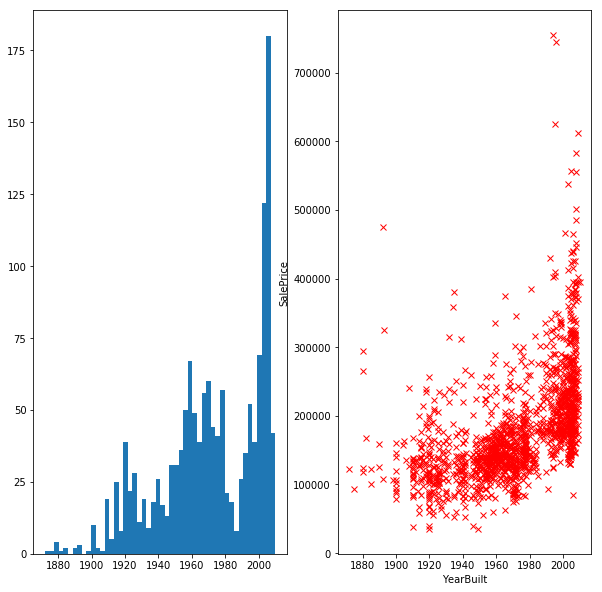

In [5]:
features_to_plot = ["LotArea", "PoolArea", "YearBuilt"]
for fname in features_to_plot:
    plot_feature(fname, df_train)

(array([   5.,   11.,   13.,   61.,   58.,  126.,  165.,  180.,  122.,
         130.,  121.,   78.,   61.,   64.,   49.,   36.,   36.,   25.,
          13.,   25.,   16.,   11.,    4.,   11.,    9.,    5.,    4.,
           4.,    4.,    2.,    1.,    1.,    1.,    0.,    1.,    0.,
           2.,    0.,    1.,    0.,    2.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    2.]),
 array([  34900.,   49302.,   63704.,   78106.,   92508.,  106910.,
         121312.,  135714.,  150116.,  164518.,  178920.,  193322.,
         207724.,  222126.,  236528.,  250930.,  265332.,  279734.,
         294136.,  308538.,  322940.,  337342.,  351744.,  366146.,
         380548.,  394950.,  409352.,  423754.,  438156.,  452558.,
         466960.,  481362.,  495764.,  510166.,  524568.,  538970.,
         553372.,  567774.,  582176.,  596578.,  610980.,  625382.,
         639784.,  654186.,  668588.,  682990.,  697392.,  711794.,
         726196.,  740598.,  755000.]),
 <a list of 50 P

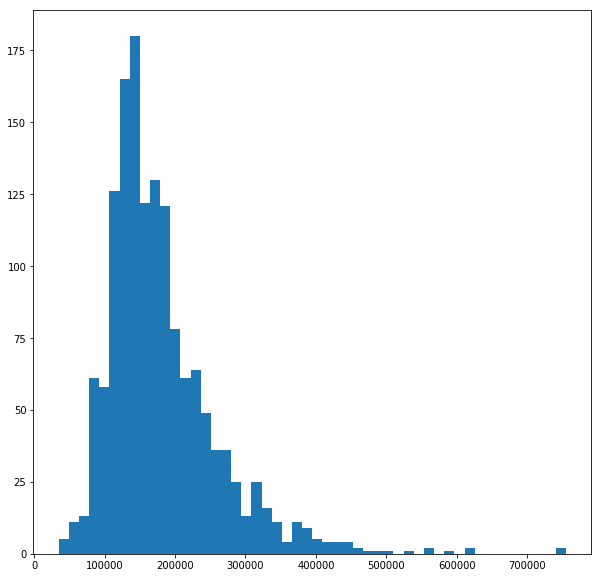

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.hist(df_train["SalePrice"],bins=50)

We see that several features are skewed, including the objective variable

## Handling categorical variables

In this first try, we will pass from categorical to numerical by classing each categorical acording to its mean impact in the price. The result is a dictionary in order to be able to utilize it in the test set.

In [7]:
def class_by_mean_price(df,feature_name):
    dic={}
    values = eval('df.'+feature_name+'.unique()')
    key=np.zeros((len(values)))
    for i in range(len(values)):
        A=df.loc[df[feature_name]==values[i]]
        key[i]=A['SalePrice'].mean()
    sorted_values=[x for (y,x) in sorted(zip(key,values))]
    for i in range(len(sorted_values)):
        dic[sorted_values[i]]=i
    return dic    


def modify_feature_dic(df, feature_name, dic):
    df_mod=df
    values = eval('df_mod.'+feature_name+'.unique()')
    for i in range(len(values)):
        if values[i] in dic:
            df_mod.loc[df_mod[feature_name]==values[i],feature_name]=float(dic[values[i]])
        else:
            df_mod.loc[df_mod[feature_name]==values[i],feature_name]=0
    return df_mod

In [8]:
headers=list(df_train.columns.values)
for i in headers:
    if type(df_train[i][1]) is str:
        #get dic using train
        dic=class_by_mean_price(df_train,i)
        #apply dic to train and test
        df_train=modify_feature_dic(df_train,i,dic)
        df_test=modify_feature_dic(df_test,i,dic) #PROBLEME ICCCIIIII
    

In [9]:
y_train = df_train['SalePrice']
x_train = df_train.drop('SalePrice',axis=1)

x_test = df_test

## Handling Skewed features

In order to have features with a more symetric behaviour, we will apply a log(x + 1) function to our data.

In [10]:
skewed_corrections=[]
ind=1
previous_length=0
numeric_feats = x_train.dtypes[x_train.dtypes != "object"].index
while ind==1:
    skewed_feats = x_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    if previous_length==len(skewed_feats):
        ind=0
    previous_length=len(skewed_feats)   
    x_train[skewed_feats] = np.log1p(x_train[skewed_feats])
    skewed_corrections.append(skewed_feats)
    
#applying to test:
for i in skewed_corrections:
    x_test[i]=np.log1p(x_test[i])

(array([   5.,   11.,   13.,   61.,   58.,  126.,  165.,  180.,  122.,
         130.,  121.,   78.,   61.,   64.,   49.,   36.,   36.,   25.,
          13.,   25.,   16.,   11.,    4.,   11.,    9.,    5.,    4.,
           4.,    4.,    2.,    1.,    1.,    1.,    0.,    1.,    0.,
           2.,    0.,    1.,    0.,    2.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    2.]),
 array([  34900.,   49302.,   63704.,   78106.,   92508.,  106910.,
         121312.,  135714.,  150116.,  164518.,  178920.,  193322.,
         207724.,  222126.,  236528.,  250930.,  265332.,  279734.,
         294136.,  308538.,  322940.,  337342.,  351744.,  366146.,
         380548.,  394950.,  409352.,  423754.,  438156.,  452558.,
         466960.,  481362.,  495764.,  510166.,  524568.,  538970.,
         553372.,  567774.,  582176.,  596578.,  610980.,  625382.,
         639784.,  654186.,  668588.,  682990.,  697392.,  711794.,
         726196.,  740598.,  755000.]),
 <a list of 50 P

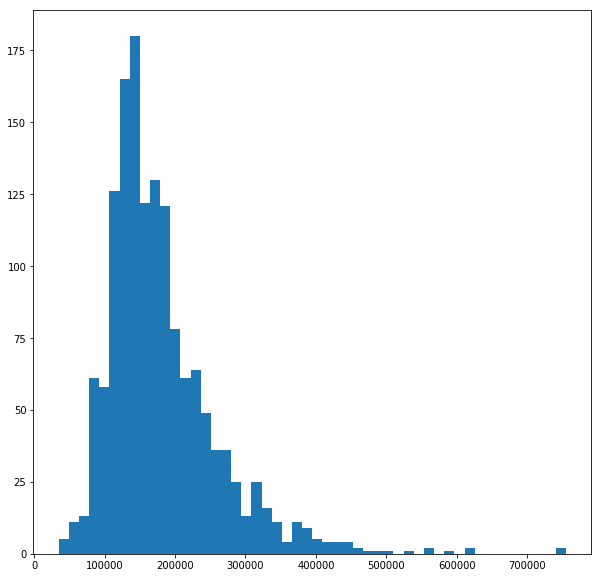

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.hist(y_train,bins=50)

In [12]:
scale = preprocessing.StandardScaler()
scale.fit(x_train)
x_train_scaled = scale.transform(x_train)
x_test_scaled = scale.transform(x_test)

## Train and validation set

We will separe the train set in train and cross validation. This will allow to have an idea of the performance of our algorithm before submitting

In [13]:
train_population = np.random.rand(len(x_train_scaled)) < 0.8
x_cv_scaled = x_train_scaled[~train_population]
x_train_scaled = x_train_scaled[train_population]
y_cv = y_train[~train_population]
y_train = y_train[train_population]

y_train_ns = np.log1p(np.log1p(y_train))
y_cv_ns = np.log1p(np.log1p(y_cv))

## First Linear models

I decided to try two linear models, to see their performance. One is bayesian Ridge and other Lasso. The parameters have been tested using the cross validation set previously

In [14]:
def R2_score(y_prev, y):
    u = np.sum(np.square(y - y_prev))
    v = np.sum(np.square(y - np.mean(y)))
    score = 1 - (u/v)
    return score

In [15]:
clf_bayesian = BayesianRidge(n_iter = 10000,tol = 1e-6,alpha_1 = 1e-06,alpha_2 = 0.23099999999999998)
clf_bayesian.fit(x_train_scaled, y_train_ns)
print(R2_score(np.expm1(np.expm1(clf_bayesian.predict(x_cv_scaled))), y_cv))

0.887861500757


In [16]:
clf_lasso = Lasso(alpha=0.00010999999999999999, max_iter=10000, tol=1e-6)
clf_lasso.fit(x_train_scaled, y_train_ns)
print(R2_score(np.expm1(np.expm1(clf_lasso.predict(x_cv_scaled))), y_cv))

0.901412143264


### Results of the linear models

Let's see some of the results obtained

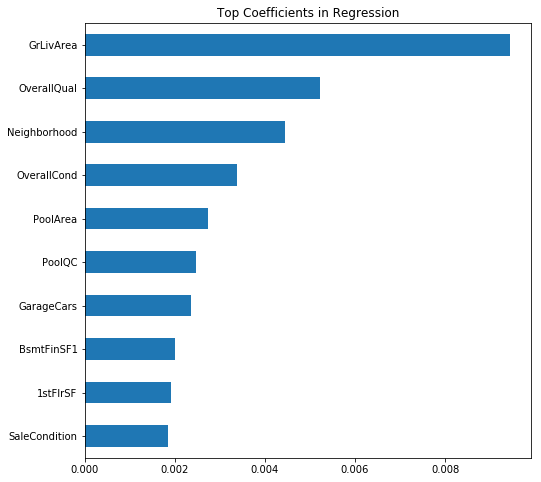

In [17]:
coef = pd.Series(clf_lasso.coef_, index = x_train.columns)
coef_sorted = coef.sort_values()
coef_sorted_abs=np.abs(coef).sort_values()
petits=coef_sorted_abs[coef_sorted_abs<1e-10]
exclude=petits.axes[0]
plt.rcParams['figure.figsize'] = (8.0, 8.0)
coef_sorted_abs[-10:].plot(kind = "barh")
plt.title("Top Coefficients in Regression")



BldgType        0.0
MasVnrArea      0.0
LotFrontage     0.0
MoSold          0.0
Exterior2nd     0.0
2ndFlrSF        0.0
LotShape        0.0
GarageYrBlt     0.0
GarageType      0.0
BsmtFinSF2      0.0
LandSlope       0.0
3SsnPorch       0.0
BsmtHalfBath    0.0
Fence           0.0
MiscFeature     0.0
BsmtFinType1    0.0
dtype: float64


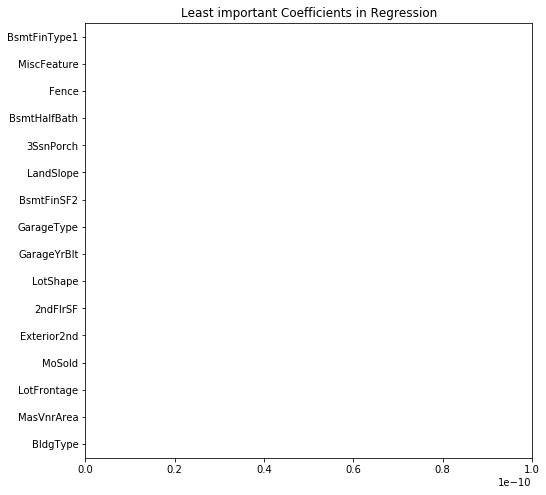

In [18]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
petits.plot(kind = "barh")
plt.title("Least important Coefficients in Regression")
plt.xlim([0, 1e-10])
print(petits)

We see that some of the highly utilized variables are well understood, as General Living area. We also see that some features are not being used at all. We decide to exclude them from the data set, even though they might have some nonlinear impact that is not tested.

In [19]:
x_train_2 = x_train.drop(exclude,axis=1)
x_test_2 = x_test.drop(exclude,axis=1)
scale.fit(x_train_2)
x_train_2_scaled=scale.transform(x_train_2)
x_test_2_scaled=scale.transform(x_test_2)

x_cv_2_scaled = x_train_2_scaled[~train_population]
x_train_2_scaled = x_train_2_scaled[train_population]

In [20]:
clf_lasso_2 = Lasso(alpha=0.000396,max_iter=10000,tol=1e-6)
clf_lasso_2.fit(x_train_2_scaled, y_train_ns)
print(R2_score(np.expm1(np.expm1(clf_lasso_2.predict(x_cv_2_scaled))), y_cv))

0.897997120568


In [21]:
clf_ridge_2 = BayesianRidge(n_iter=10000, tol=1e-6, alpha_1=1e-06, alpha_2=0.23099999999999998)
clf_ridge_2.fit(x_train_2_scaled, y_train_ns)
print(R2_score(np.expm1(np.expm1(clf_ridge_2.predict(x_cv_2_scaled))), y_cv))

0.893782758351


We see that we have improved on both results by excluding the not used variables. 

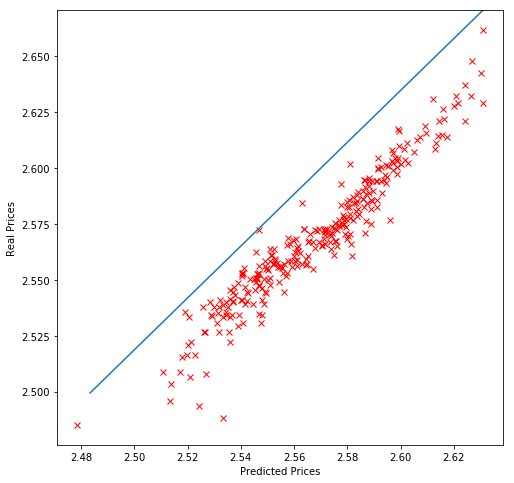

In [22]:
plt.plot(clf_lasso_2.predict(x_cv_2_scaled), y_cv_ns, 'rx')
plt.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.xlabel("Predicted Prices")
plt.ylabel("Real Prices")

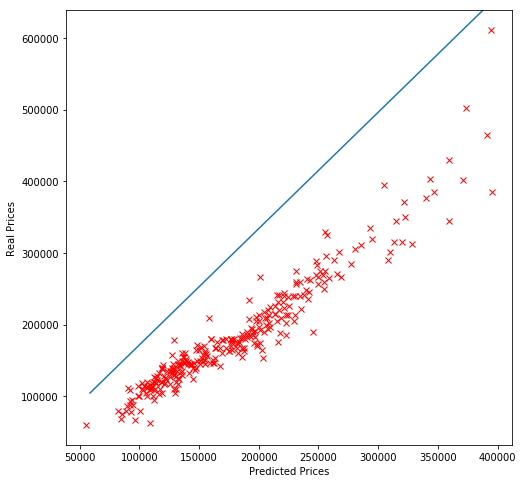

In [23]:
plt.plot(np.expm1(np.expm1(clf_lasso_2.predict(x_cv_2_scaled))), y_cv, 'rx')
plt.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.xlabel("Predicted Prices")
plt.ylabel("Real Prices")

We see that even though we have a high $R^2$ score, our prediction is not really top. Thus, we will pass to a non-linear model

## Non- Linear model

I decide to use a neural network in the residuals of the best regression. As we do not have a lot of data, is fundamental to avoid overfitting of the network. I could use batch normalization training, but decided to spare some trouble and use dropout for the moment

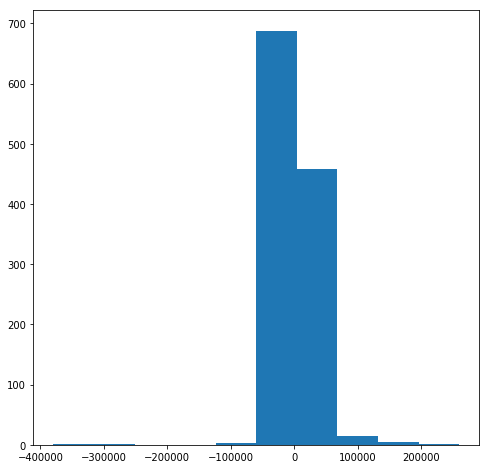

In [24]:
residuals = y_train - np.expm1(np.expm1(clf_lasso_2.predict(x_train_2_scaled)))
residuals_cv = y_cv - np.expm1(np.expm1(clf_lasso_2.predict(x_cv_2_scaled)))
plt.hist(residuals)
residuals= np.transpose(np.array([residuals]))
residuals_cv= np.transpose(np.array([residuals_cv]))

For the neural network I'll use a class that I implemented based on Tensorflow

In [25]:
import nn_mlp as rn
archi = [x_train_scaled.shape[1], 100, 100,1]
reseau = rn.NN_mlp(archi, actfun=['sigmoid', 'relu'], cost='MSE')

OBS: Results are available at a tensorboard session

In [26]:
reseau.train(X = x_train_scaled, Y = residuals, n_iter = 5000, min_step = 1e-1, sum_flag = True, sum_dir = 'log_nn_residual/submit', drop_layers=np.array([0,1,2]),
             prob_drops=[0.7, 0.5, 0.5], cross_flag = True, X_cross = x_cv_scaled, Y_cross = residuals_cv)
reseau.train(X = x_train_scaled, Y = residuals, n_iter = 5000, min_step = 1e-2, sum_flag = True, sum_dir = 'log_nn_residual/submit', drop_layers=np.array([0,1,2]),
             prob_drops=[0.7, 0.5, 0.5], cross_flag = True, X_cross = x_cv_scaled, Y_cross = residuals_cv)
reseau.train(X = x_train_scaled, Y = residuals, n_iter = 10000, min_step = 1e-4, sum_flag = True, sum_dir = 'log_nn_residual/submit', drop_layers=np.array([0,1,2]),
             prob_drops=[0.7, 0.5, 0.5], cross_flag = True, X_cross = x_cv_scaled, Y_cross = residuals_cv)

In [27]:
reseau.cost='MAE'
reseau.train(x_train_scaled, residuals, 1000,1e-4,True, 'log_nn_residual/submit',drop_layers=np.array([0,1,2]),
             prob_drops=[0.7, 0.5, 0.5])
reseau.cost='MSE'
reseau.train(x_train_scaled, residuals, 1000,1e-4,True, 'log_nn_residual/submit',drop_layers=np.array([0,1,2]),
             prob_drops=[0.7, 0.5, 0.5], cross_flag = True, X_cross = x_cv_scaled, Y_cross = residuals_cv)


In [28]:
y_reseau = reseau.predict(x_cv_scaled)
y_lasso = np.expm1(np.expm1(clf_lasso_2.predict(x_cv_2_scaled)))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


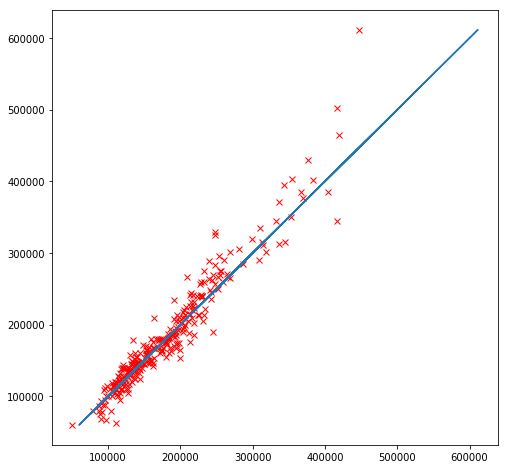

In [29]:
plt.plot(y_reseau + y_lasso, y_cv, 'rx')
plt.plot(y_cv, y_cv)


In [30]:
R2_score(y_reseau + y_lasso, y_cv)

0.92337791443083517